<a href="https://www.kaggle.com/code/maro22/notebook0b7eae9c66?scriptVersionId=213728432" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import random
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.layers import Dropout
from keras.initializers import RandomNormal
from keras.initializers import Zeros
from keras.initializers import Ones
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from imutils import paths
import gc
from keras.regularizers import l2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import *
from keras.layers import *
import os
from imutils import paths
from keras import backend as K
from tensorflow.keras.optimizers import SGD
import matplotlib
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import gc
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


# **Preprocessing**

In [3]:
INPUT_SHAPE = (224, 224, 3)
AXIS = 3
NUM_CLASSES = 7

In [4]:
train_dataset="../input/cars-image-dataset/Cars Dataset/train"
test_dataset="../input/cars-image-dataset/Cars Dataset/test"

In [5]:
# Collect image paths
train_imagePaths = list(paths.list_images(train_dataset))
test_imagePaths = list(paths.list_images(test_dataset))

In [6]:
all_imagePaths = train_imagePaths + test_imagePaths
random.seed(42)
random.shuffle(all_imagePaths)

In [7]:
# Calculate channel means using training data
B_mean, G_mean, R_mean, count = 0, 0, 0, 0
for imagePath in train_imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    B_mean += np.mean(image[:, :, 0])
    G_mean += np.mean(image[:, :, 1])
    R_mean += np.mean(image[:, :, 2])
    count += 1
B_mean /= count
G_mean /= count
R_mean /= count
mean = [B_mean, G_mean, R_mean]


In [8]:
# Function to load and preprocess images
def load_and_preprocess_images(imagePaths, mean):
    data, labels = [], []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image -= mean
        data.append(image)
        
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    return data, labels

In [9]:
# Load and preprocess training and test data
all_data, all_labels = load_and_preprocess_images(all_imagePaths, mean)

# Encode labels
le = LabelEncoder()
all_labels = le.fit_transform(all_labels)
all_labels = to_categorical(all_labels, num_classes=len(le.classes_))

In [10]:
# Split the combined data into train, validation, and test sets
trainX, tempX, trainY, tempY = train_test_split(all_data, all_labels, test_size=0.3, random_state=42)
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

# Data augmentation
aug = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=2, restore_best_weights=True)

# ResNet34 Architecture

In [11]:
class ResNet34:
     def build(inputShape,classes):

            
        def Conv(inputs,kernels,size=(1,1),padding='same',strides=(1,1),relu=True,BN=True):
            net=Conv2D(kernels,size,strides=strides,padding=padding)(inputs)
            if BN:
                net=BatchNormalization()(net)
            if relu:
                net=Activation('relu')(net)
            return net
        
        def residual(inputs,kernels,first=False):
            if first:
                net=Conv(inputs,kernels,size=(3,3),strides=(2,2))
            else:
                net=Conv(inputs,kernels,size=(3,3))
            net=Conv(net,kernels,size=(3,3))
            if first:
                inputs=Conv(inputs,kernels,relu=False,strides=(2,2),BN=False)
            Add=add([net,inputs])
            net=BatchNormalization()(Add)
            net=Activation('relu')(net)
            return net
        
        X=Input(shape=inputShape)
        net=Conv(X,64,(7,7),strides=(2,2))
        
        net=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(net)
        net=residual(inputs=net,kernels=64)
        net=residual(inputs=net,kernels=64)
        net=residual(inputs=net,kernels=64)
        
        net=residual(inputs=net,kernels=128,first=True)
        net=residual(inputs=net,kernels=128)
        net=residual(inputs=net,kernels=128)
        net=residual(inputs=net,kernels=128)
        
        net=residual(inputs=net,kernels=256,first=True)
        net=residual(inputs=net,kernels=256)
        net=residual(inputs=net,kernels=256)
        net=residual(inputs=net,kernels=256)
        net=residual(inputs=net,kernels=256)
        net=residual(inputs=net,kernels=256)
        
        net=residual(inputs=net,kernels=512,first=True)
        net=residual(inputs=net,kernels=512)
        net=residual(inputs=net,kernels=512)
        
        net=GlobalAveragePooling2D()(net)
        
        outputs=Dense(classes,activation="softmax")(net)
        
        model=Model(X,outputs)
        
        return model

In [12]:
# Model setup (assuming ResNet is defined elsewhere)
model = ResNet34.build(INPUT_SHAPE, 7)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

# Train the model
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=32),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // 32,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734536440.776818    4528 service.cc:145] XLA service 0x78c6d8001d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734536440.776889    4528 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734536440.776893    4528 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734536458.431893    4528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 9/91 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.1769 - loss: 2.1910  

I0000 00:00:1734536475.282040    4529 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_63', 192 bytes spill stores, 192 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_184', 56 bytes spill stores, 56 bytes spill loads



91/91 ━━━━━━━━━━━━━━━━━━━━ 88s 512ms/step - accuracy: 0.2463 - loss: 1.9692 - val_accuracy: 0.2400 - val_loss: 3.0647
Epoch 2/100
 1/91 ━━━━━━━━━━━━━━━━━━━━ 17s 197ms/step - accuracy: 0.2500 - loss: 1.8393

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2500 - loss: 1.8393 - val_accuracy: 0.2400 - val_loss: 3.3745
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.3395 - loss: 1.7570 - val_accuracy: 0.2224 - val_loss: 7.3387
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4688 - loss: 1.6861 - val_accuracy: 0.2112 - val_loss: 8.6911
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.3704 - loss: 1.7412 - val_accuracy: 0.3024 - val_loss: 10.3294
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4062 - loss: 1.5185 - val_accuracy: 0.2928 - val_loss: 10.3022
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.4096 - loss: 1.6203 - val_accuracy: 0.3888 - val_loss: 1.8603
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4688 - loss: 1.5512 - val_accuracy: 0.3856 - val_loss: 1.8688
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - accuracy: 0.4234 - loss: 1.5477 - val_accuracy: 0.28

In [13]:
loss, accuracy = model.evaluate(testX, testY)
print("Test accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8642 - loss: 0.4870
Test accuracy: 0.8831999897956848


In [14]:
predictions = model.predict(testX)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(testY, axis=1)

report = classification_report(true_classes, pred_classes, target_names=le.classes_)
print(report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step
                  precision    recall  f1-score   support

            Audi       0.93      0.87      0.90       156
   Hyundai Creta       0.85      0.92      0.88        50
Mahindra Scorpio       0.81      0.93      0.86        58
     Rolls Royce       0.79      0.92      0.85        60
           Swift       0.93      0.75      0.83        76
     Tata Safari       0.90      0.88      0.89        86
   Toyota Innova       0.90      0.92      0.91       139

        accuracy                           0.88       625
       macro avg       0.87      0.88      0.88       625
    weighted avg       0.89      0.88      0.88       625



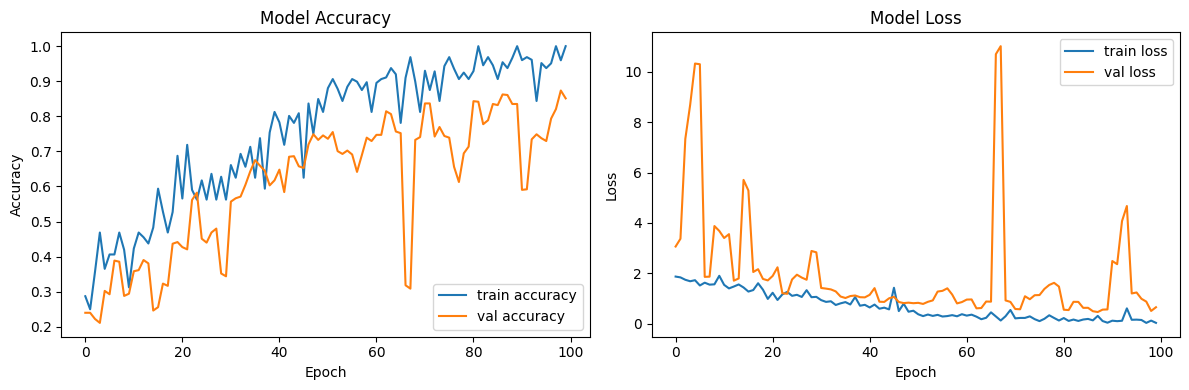

In [15]:
import matplotlib.pyplot as plt

# Assuming `H` is the history object returned by model.fit()
def plot_accuracy_and_loss(H):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(H.history['accuracy'], label='train accuracy')
    plt.plot(H.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(H.history['loss'], label='train loss')
    plt.plot(H.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_accuracy_and_loss(H)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


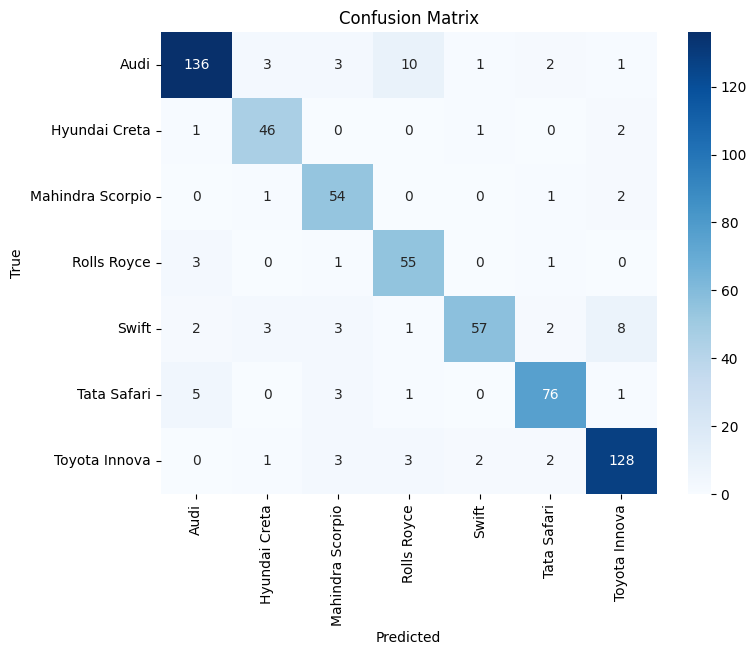

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming `testY` are the true labels and `predictions` are the predicted labels
def plot_confusion_matrix(testY, predictions, class_names):
    cm = confusion_matrix(testY, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
predictions = model.predict(testX).argmax(axis=1)
true_labels = testY.argmax(axis=1)
plot_confusion_matrix(true_labels, predictions, class_names=le.classes_)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


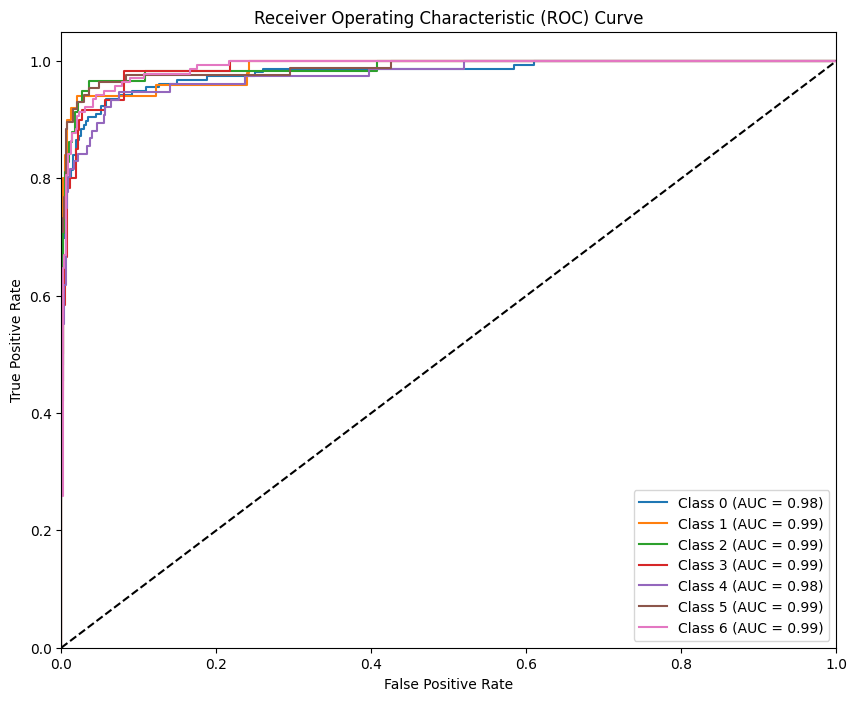

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming `testY` are the true labels and `predictions` are the predicted probabilities
def plot_roc_auc(testY, predictions, num_classes):
    # Binarize the output
    testY_bin = label_binarize(testY, classes=range(num_classes))
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
predictions_prob = model.predict(testX)
plot_roc_auc(true_labels, predictions_prob, num_classes=len(le.classes_))

 ------
 ------

# Densnet Arcticture Model

In [18]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (optional if fine-tuning is not required)
densenet.trainable = False

for layer in densenet.layers[-100:]:
    layer.trainable = True


In [19]:
# Build the model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
model2 = models.Sequential([
    densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')
])



model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history2 = model2.fit(
    
    x=aug.flow(trainX, trainY, batch_size=32),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // 32,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 118s 738ms/step - accuracy: 0.6048 - loss: 1.1153 - val_accuracy: 0.7248 - val_loss: 1.6802
Epoch 2/100
 1/91 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.8438 - loss: 0.2935

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8438 - loss: 0.2935 - val_accuracy: 0.7232 - val_loss: 1.8628
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 290ms/step - accuracy: 0.9223 - loss: 0.2332 - val_accuracy: 0.9408 - val_loss: 0.1917
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9375 - loss: 0.1129 - val_accuracy: 0.9360 - val_loss: 0.2009
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.9624 - loss: 0.1089 - val_accuracy: 0.9280 - val_loss: 0.3470
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9688 - loss: 0.1643 - val_accuracy: 0.9248 - val_loss: 0.3405
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.9647 - loss: 0.1090 - val_accuracy: 0.8832 - val_loss: 0.4475
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8750 - loss: 0.3662 - val_accuracy: 0.8864 - val_loss: 0.4576
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.9576 - loss: 0.1260 - val_accuracy: 0.9488

In [21]:
loss, accuracy = model2.evaluate(testX, testY)
print("Test accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9433 - loss: 0.2042
Test accuracy: 0.9391999840736389


In [22]:
predictions = model2.predict(testX)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(testY, axis=1)

report = classification_report(true_classes, pred_classes, target_names=le.classes_)
print(report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step
                  precision    recall  f1-score   support

            Audi       0.95      0.94      0.94       156
   Hyundai Creta       0.82      0.92      0.87        50
Mahindra Scorpio       0.98      0.91      0.95        58
     Rolls Royce       0.96      0.88      0.92        60
           Swift       0.84      0.99      0.91        76
     Tata Safari       0.99      0.94      0.96        86
   Toyota Innova       0.99      0.96      0.97       139

        accuracy                           0.94       625
       macro avg       0.93      0.93      0.93       625
    weighted avg       0.94      0.94      0.94       625



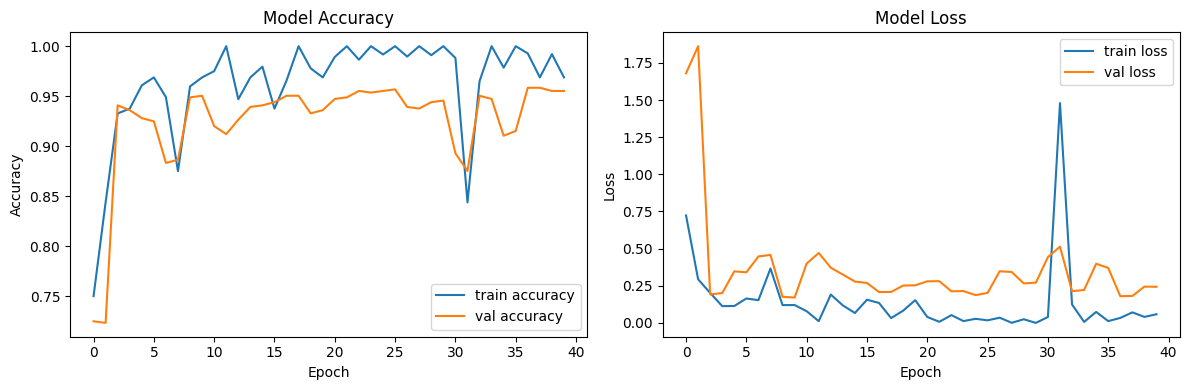

In [23]:
import matplotlib.pyplot as plt

# Assuming `H` is the history object returned by model.fit()
def plot_accuracy_and_loss(H):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(H.history['accuracy'], label='train accuracy')
    plt.plot(H.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(H.history['loss'], label='train loss')
    plt.plot(H.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_accuracy_and_loss(history2)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


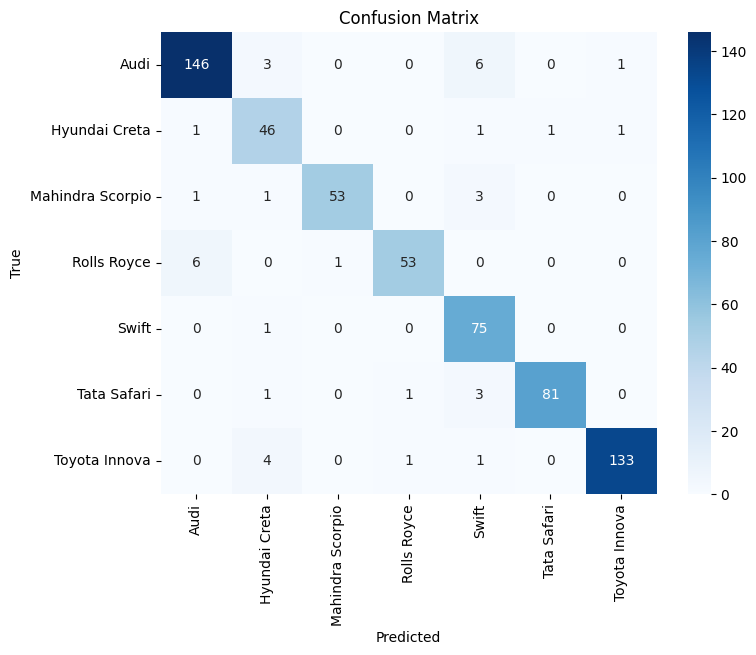

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming `testY` are the true labels and `predictions` are the predicted labels
def plot_confusion_matrix(testY, predictions, class_names):
    cm = confusion_matrix(testY, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
predictions = model2.predict(testX).argmax(axis=1)
true_labels = testY.argmax(axis=1)
plot_confusion_matrix(true_labels, predictions, class_names=le.classes_)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


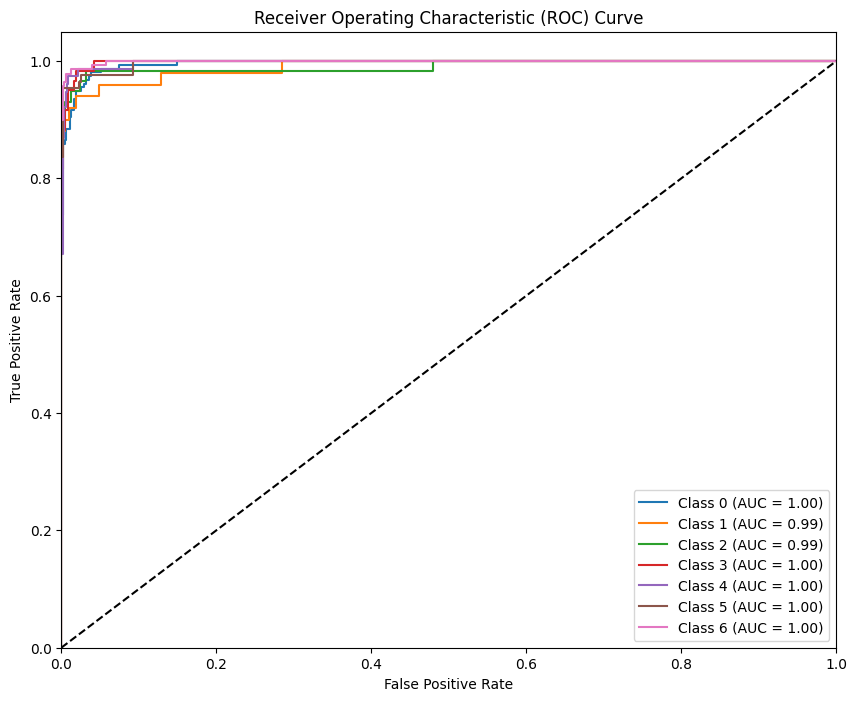

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming `testY` are the true labels and `predictions` are the predicted probabilities
def plot_roc_auc(testY, predictions, num_classes):
    # Binarize the output
    testY_bin = label_binarize(testY, classes=range(num_classes))
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
predictions_prob = model2.predict(testX)
plot_roc_auc(true_labels, predictions_prob, num_classes=len(le.classes_))

-------
-------

# Xception Arcticture Model

In [26]:
from tensorflow.keras.applications import Xception

xception = Xception(weights='imagenet', include_top=False)

xception.trainable = False

for layer in xception.layers[-100:]:
    layer.trainable = True

In [27]:
model3 = models.Sequential([
    xception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')
])


In [28]:
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
history3 = model3.fit(
    
    x=aug.flow(trainX, trainY, batch_size=32),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // 32,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 99s 614ms/step - accuracy: 0.5389 - loss: 1.3320 - val_accuracy: 0.5344 - val_loss: 5.8828
Epoch 2/100
 1/91 ━━━━━━━━━━━━━━━━━━━━ 29s 327ms/step - accuracy: 0.9062 - loss: 0.3918

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9062 - loss: 0.3918 - val_accuracy: 0.5392 - val_loss: 5.7631
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 357ms/step - accuracy: 0.9009 - loss: 0.3669 - val_accuracy: 0.7408 - val_loss: 1.2931
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9375 - loss: 0.1303 - val_accuracy: 0.7792 - val_loss: 1.0645
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 347ms/step - accuracy: 0.9042 - loss: 0.3649 - val_accuracy: 0.8320 - val_loss: 0.6733
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9375 - loss: 0.3547 - val_accuracy: 0.8608 - val_loss: 0.5947
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 352ms/step - accuracy: 0.9270 - loss: 0.2433 - val_accuracy: 0.8624 - val_loss: 0.6749
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9062 - loss: 0.2851 - val_accuracy: 0.8624 - val_loss: 0.7854
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 351ms/step - accuracy: 0.9428 - loss: 0.2287 - val_accuracy: 0.8848

In [30]:
loss, accuracy = model3.evaluate(testX, testY)
print("Test accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9722 - loss: 0.1630
Test accuracy: 0.9775999784469604


In [31]:
predictions = model3.predict(testX)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(testY, axis=1)

report = classification_report(true_classes, pred_classes, target_names=le.classes_)
print(report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step
                  precision    recall  f1-score   support

            Audi       0.97      0.99      0.98       156
   Hyundai Creta       0.98      0.96      0.97        50
Mahindra Scorpio       0.98      0.97      0.97        58
     Rolls Royce       0.98      0.95      0.97        60
           Swift       0.95      0.99      0.97        76
     Tata Safari       0.99      0.98      0.98        86
   Toyota Innova       0.99      0.98      0.98       139

        accuracy                           0.98       625
       macro avg       0.98      0.97      0.98       625
    weighted avg       0.98      0.98      0.98       625



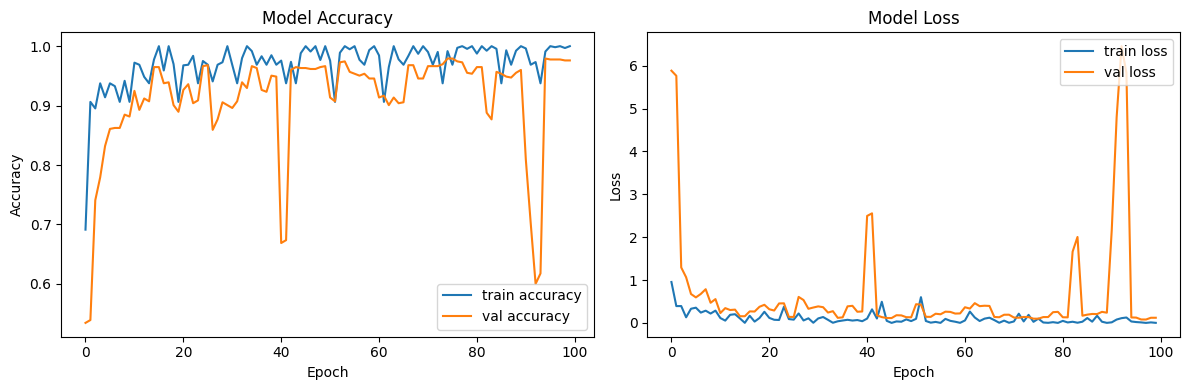

In [32]:
import matplotlib.pyplot as plt

# Assuming `H` is the history object returned by model.fit()
def plot_accuracy_and_loss(H):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(H.history['accuracy'], label='train accuracy')
    plt.plot(H.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(H.history['loss'], label='train loss')
    plt.plot(H.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_accuracy_and_loss(history3)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


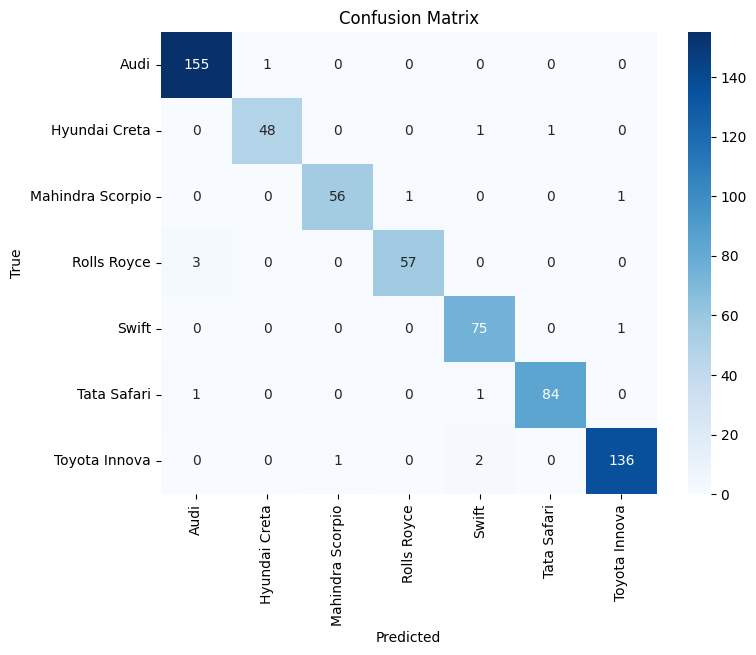

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming `testY` are the true labels and `predictions` are the predicted labels
def plot_confusion_matrix(testY, predictions, class_names):
    cm = confusion_matrix(testY, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
predictions = model3.predict(testX).argmax(axis=1)
true_labels = testY.argmax(axis=1)
plot_confusion_matrix(true_labels, predictions, class_names=le.classes_)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


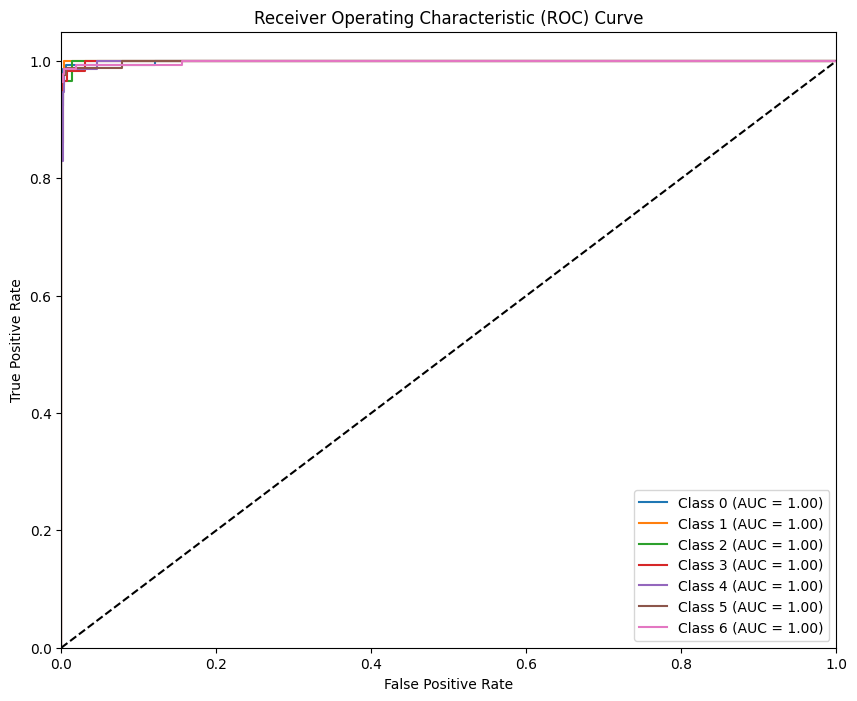

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming `testY` are the true labels and `predictions` are the predicted probabilities
def plot_roc_auc(testY, predictions, num_classes):
    # Binarize the output
    testY_bin = label_binarize(testY, classes=range(num_classes))
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
predictions_prob = model3.predict(testX)
plot_roc_auc(true_labels, predictions_prob, num_classes=len(le.classes_))